# MultiLinear regression models

## Linear regression theory

We assume here that $ y | X ; \theta\sim\mathcal{N}(\mu,\sigma ^2)$!!

* **Normal equations** - By noting $X$ the design matrix, the value of $\theta$ that minimizes the cost function is a closed-form solution such that:

$$
\boxed{\theta=(X^TX)^{-1}X^Ty}
$$ 

* **LMS algorithm** - By noting $\alpha$ the learning rate, the update rule of the Least Mean Squares (LMS) algorithm for a training set of $m$ data points, which is also known as the Widrow-Hoff learning rule, is as follows:

$$
\boxed{\forall j,\quad \theta_j \leftarrow \theta_j+\alpha\sum_{i=1}^m\left[y^{(i)}-h_\theta(x^{(i)})\right]x_j^{(i)}}
$$

```{note}
Remark: the update rule is a particular case of the gradient ascent
```

* **LWR** - Locally Weighted Regression, also known as LWR, is a variant of linear regression that weights each training example in its cost function by $w^{(i)}(x)$, which is defined with parameter $\tau\in\mathbb{R}$ as:

$$
\boxed{w^{(i)}(x)=\exp\left(-\frac{(x^{(i)}-x)^2}{2\tau^2}\right)}
$$

* **Assumptions of GLMs** - Generalized Linear Models (GLM) aim at predicting a random variable $y$ as a function of $x\in\mathbb{R}^{n+1}$ and rely on the following 3 assumptions:

$$
\quad\boxed{y|x;\theta\sim\textrm{ExpFamily}(\eta)}\textrm{    (1)}
\quad\boxed{h_\theta(x)=E[y|x;\theta]}\textrm{    (2)}
\quad\boxed{\eta=\theta^Tx}\textrm{    (3)}
$$

```{tip}
Remark: ordinary least squares and logistic regression are special cases of generalized linear models
```

In [8]:
# basics
import os, sys
import progressbar

# arrays
import numpy as np
import pandas as pd
import xarray as xr

# maths
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# append sscode to path
sys.path.insert(0, os.path.join(os.path.abspath(''), '..'))

# custom
from sscode.config import data_path, default_region_reduced
from sscode.data import Loader, load_moana_hindcast_ss, load_private_tgs
from sscode.pca import PCA_DynamicPred
from sscode.linear import MultiLinear_Regression
from sscode.plotting.utils import plot_ccrs_nz
from sscode.plotting.data import plot_uhslc_locations

# warnings
import warnings
warnings.filterwarnings('ignore')

# this is to allow plots to be centered
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Load the data (main + PCs)

As always, we load the three used datasets, which are the Moana v2 hindcast nearshore, the CFSR sea-level-pressure fields and winds (u10 and v10) and the UHSLC tgs validators, again setting the `plot` parameter to `False`.

Moreover, we will load the previously calculated regional PCs, as it takes some time to calculate them. Have in mind that principal component analysis involves "difficult" matrices multiplications / inversions, and with the regional slp fields + the gradient, we have thousands of variables!!

In [2]:
# load the data
load_cfsr_moana_uhslc = Loader(
    data_to_load=['cfsr','moana','uhslc'], plot=False
)


 loading the sea-level-pressure fields... 


 loading daily resampled data... 


 loading the Moana v2 hindcast data... 


 loading and plotting the UHSLC tidal guages... 



In [3]:
# load / calculate the pcs
if os.path.isfile('../data/cfsr/cfsr_regional_daily_pcs.nc'):
    pcs_cfsr = xr.open_dataset(
        '../data/cfsr/cfsr_regional_daily_pcs.nc'
    )
    # from sscode.plotting.pca import plot_pcs
    # plot_pcs(pcs_cfsr,n_plot=3)
else:
    # calculate the pcs
    pcs_cfsr, pcs_scaler = PCA_DynamicPred(
        load_cfsr_moana_uhslc.predictor_slp,
        calculate_gradient=True,
        pca_plot=(True,False)
    )

## Linear regression with regional predictor

In the following cell, a multilinear regression is performed over all the domain of the Moana v2 hindcast nearshore, having the regional pcs (slp + gradient) as the predictor. Moreover, we plot the obtained results, which are also saved in our `data/statistics` folder, with the name `stats_lm_regional_daily.nc`.

```{note}
As it can be seen in the results plot, the different shores in New Zealand show very different results
```

In [4]:
run = False
if run:
    # perform the Multilinear-Regression (regional)
    stats_regional = []
    sites_regional = np.arange(
        0,len(load_cfsr_moana_uhslc.predictand.site.values),5
    )
    for stat in progressbar.progressbar(sites_regional):
        ss_moana = load_cfsr_moana_uhslc.predictand.sel(site=stat)\
            .load().resample(time='1D').max()
        stats_stat = MultiLinear_Regression(
            pcs_cfsr, ss_moana, train_size=0.7,
            verbose=True, plot_results=True
        ) # pre-loaded pcs
        stats_regional.append(stats_stat)
    # save the statistics
    stats_regional = xr.Dataset(
        data_vars={
            'bias':(('station'),np.array(stats_regional)[:,0]),
            'si':(('station'),np.array(stats_regional)[:,1]),
            'rmse':(('station'),np.array(stats_regional)[:,2]),
            'pearson':(('station'),np.array(stats_regional)[:,3]),
            'spearman':(('station'),np.array(stats_regional)[:,4]),
            'rscore':(('station'),np.array(stats_regional)[:,5]),
            'latitude':(('station'),
                load_cfsr_moana_uhslc.predictand.sel(site=sites_regional).lat),
            'longitude':(('station'),
                load_cfsr_moana_uhslc.predictand.sel(site=sites_regional).lon)
        },
        coords={
            'station': sites_regional
        }
    )
    # local copy
    if False:
        stats_regional.to_netcdf(
            data_path+'/statistics/models/stats_lm_regional_daily.nc'
        )

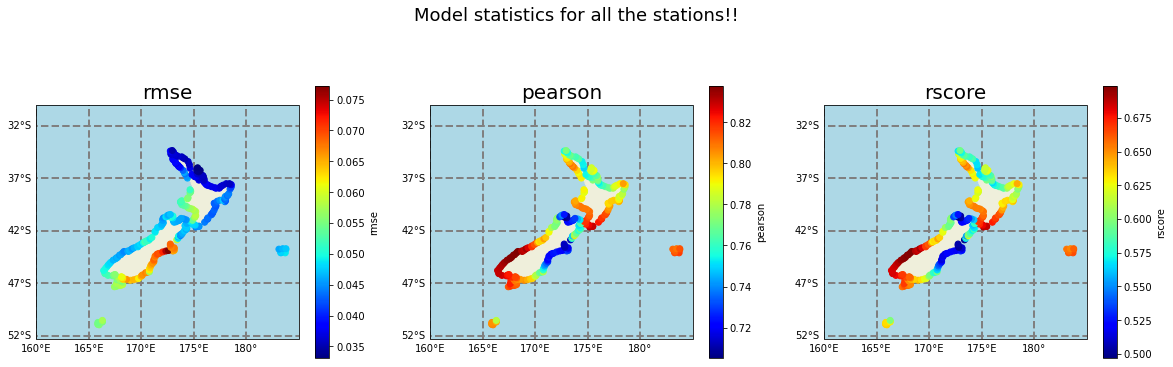

In [5]:
# plot results
if True:
    from sscode.plotting.validation import plot_stats
    stats_regional = xr.open_dataset(
        data_path+'/statistics/models/stats_lm_regional_daily.nc'
    )
    plot_stats(stats_regional,plot_stats=['rmse','pearson','rscore'])

```{tip}
Images generated by code, as the one above, can be easily open in a new window, as they have all been generated with good quality for this particular purpose!!
```

### Linear regression in the UHSLC tidal gauges + validation

Here, we really use for the first time our "validators", which are the main truth in the project. In coastal engineering, we usually use the buoys (if we are working with waves) and the tidal gauges (water elevation) as the real observations, and once they are processed, which is the case of these nodes shown here, they might be used as the data to validate with.

Below, apart from plotting the location of the different tidal gauges that we will be working with, we show how the linear regression with the regional predictor behaves in the nearest locations to the tidal gauges, and how this pre-trained linear regression model performs in that tidal gauge too.

To understand how good or bad the linear model might behave when predicting the storm surge of the tidal guages, we find the answer in the validations we performed in the first notebook, called **Data visualization and validation (data_visualization.ipynb)**, where the comparison of all the tidal gauges and the nearest moana nodes is shown.

```{warning}
This use of the pre-trained linear model with the moana nodes for the tidal gauges must be revised, as the distances between both locations might involve the appearance of new physical phenomenons!!
```

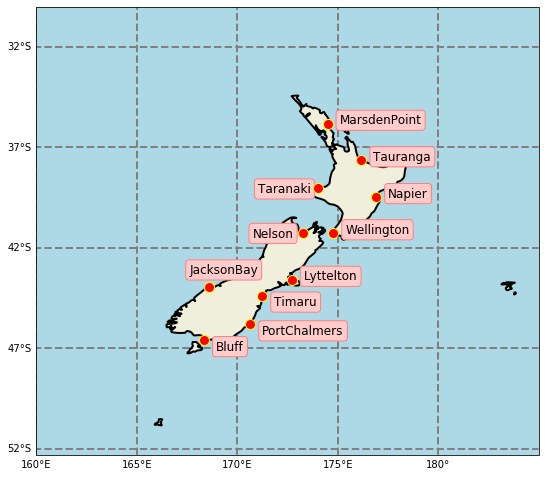

In [6]:
# plot the uhslc tidal-gauges locations
plot_uhslc_locations(load_cfsr_moana_uhslc.validator)


 139 PCs (0.95 expl. variance) will be used to train the model!! 



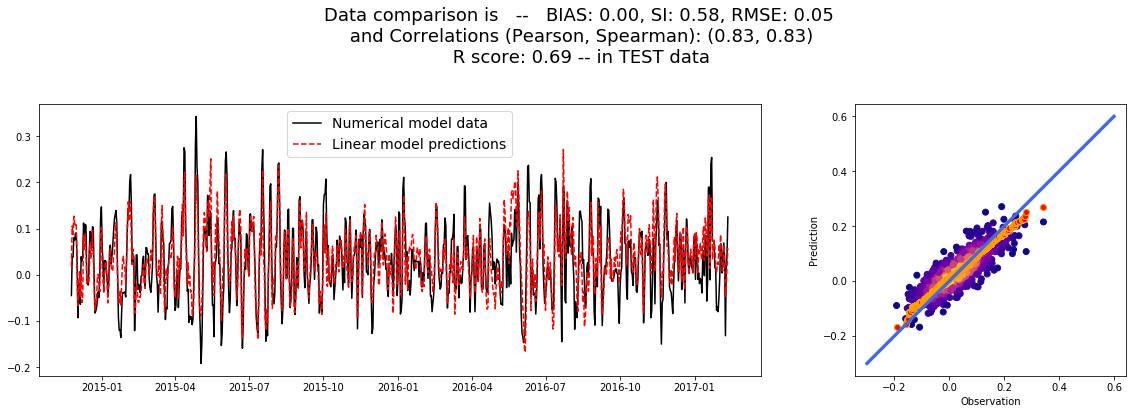

Data comparison is   --   BIAS: 0.00, SI: 0.58, RMSE: 0.05
 and Correlations (Pearson, Spearman): (0.83, 0.83)
 R score: 0.69 -- in TEST data


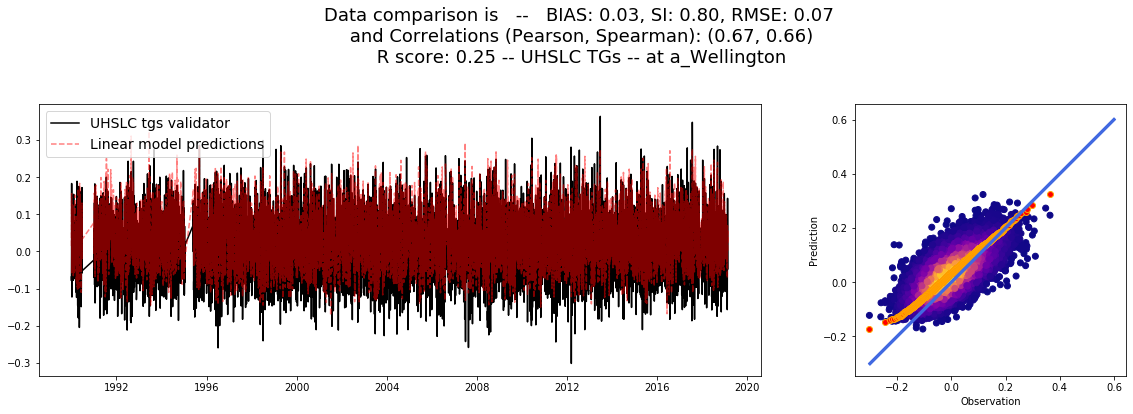


 139 PCs (0.95 expl. variance) will be used to train the model!! 



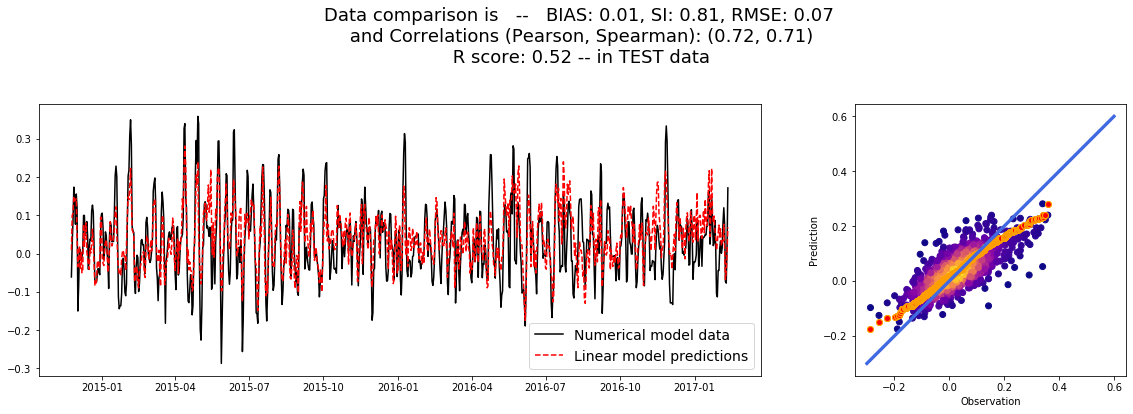

Data comparison is   --   BIAS: 0.01, SI: 0.81, RMSE: 0.07
 and Correlations (Pearson, Spearman): (0.72, 0.71)
 R score: 0.52 -- in TEST data


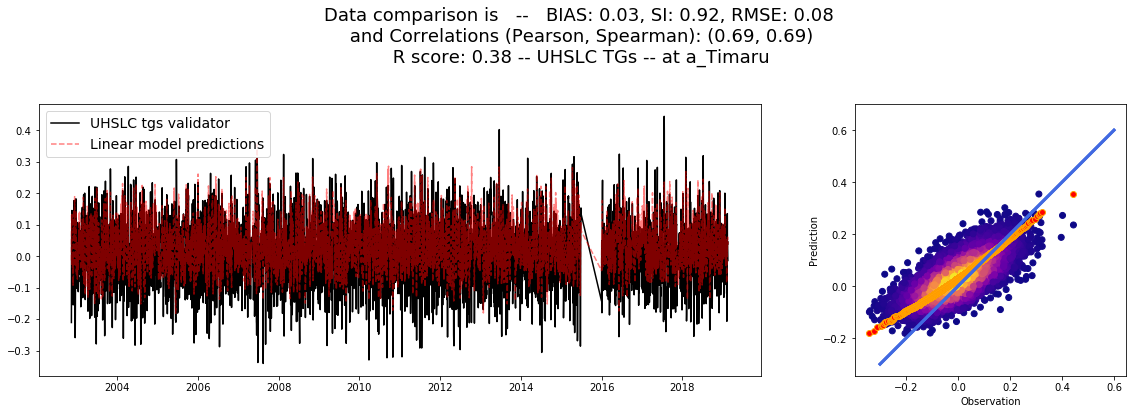


 139 PCs (0.95 expl. variance) will be used to train the model!! 



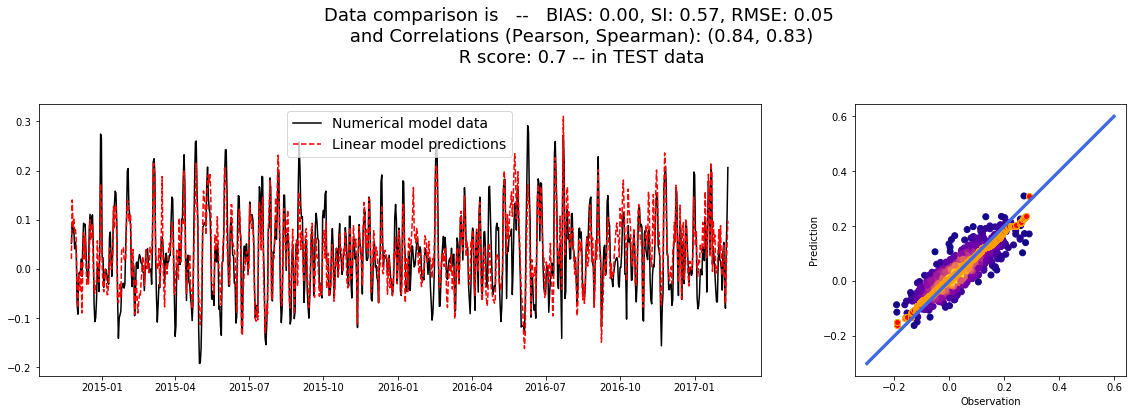

Data comparison is   --   BIAS: 0.00, SI: 0.57, RMSE: 0.05
 and Correlations (Pearson, Spearman): (0.84, 0.83)
 R score: 0.7 -- in TEST data


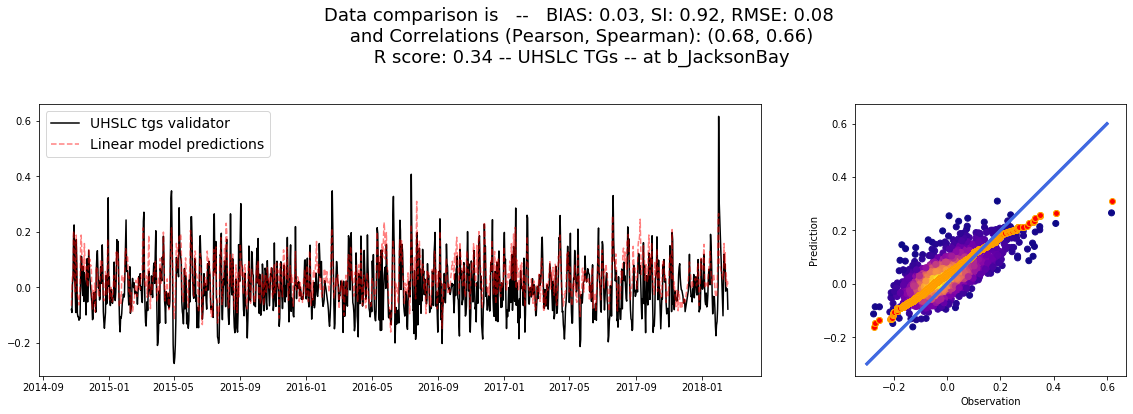


 139 PCs (0.95 expl. variance) will be used to train the model!! 



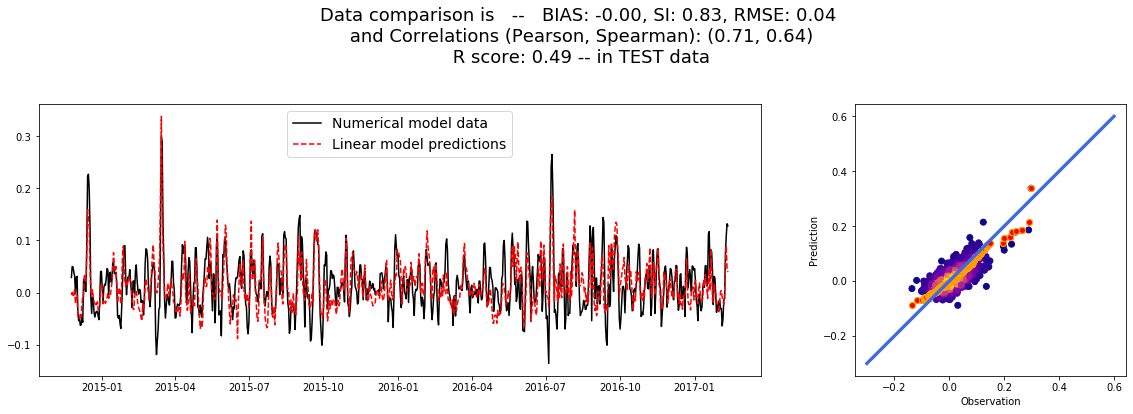

Data comparison is   --   BIAS: -0.00, SI: 0.83, RMSE: 0.04
 and Correlations (Pearson, Spearman): (0.71, 0.64)
 R score: 0.49 -- in TEST data


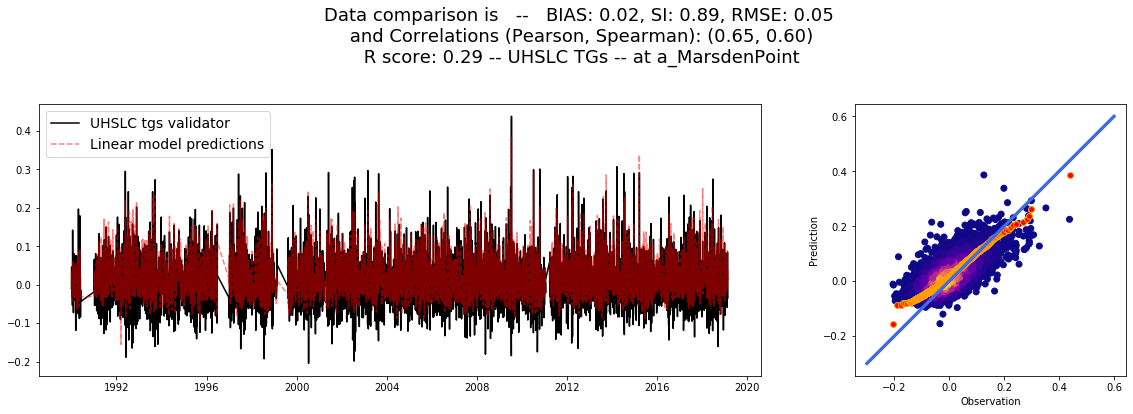


 139 PCs (0.95 expl. variance) will be used to train the model!! 



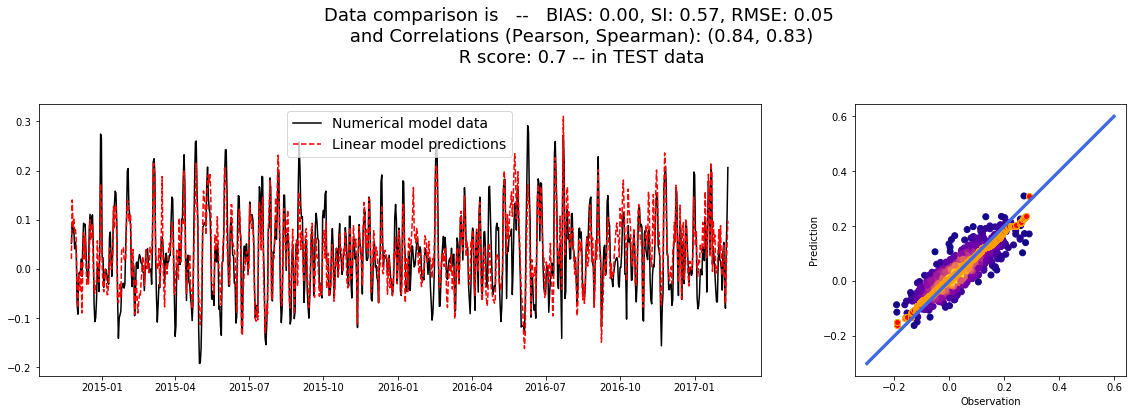

Data comparison is   --   BIAS: 0.00, SI: 0.57, RMSE: 0.05
 and Correlations (Pearson, Spearman): (0.84, 0.83)
 R score: 0.7 -- in TEST data


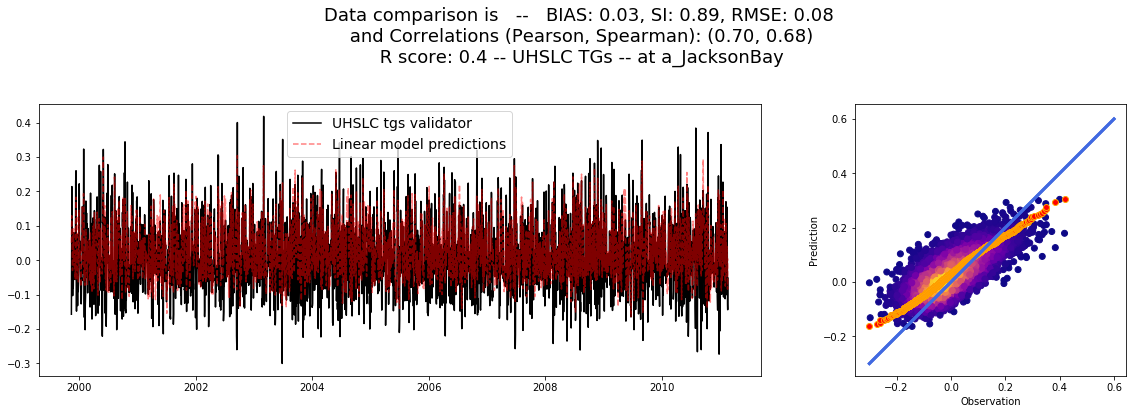


 139 PCs (0.95 expl. variance) will be used to train the model!! 



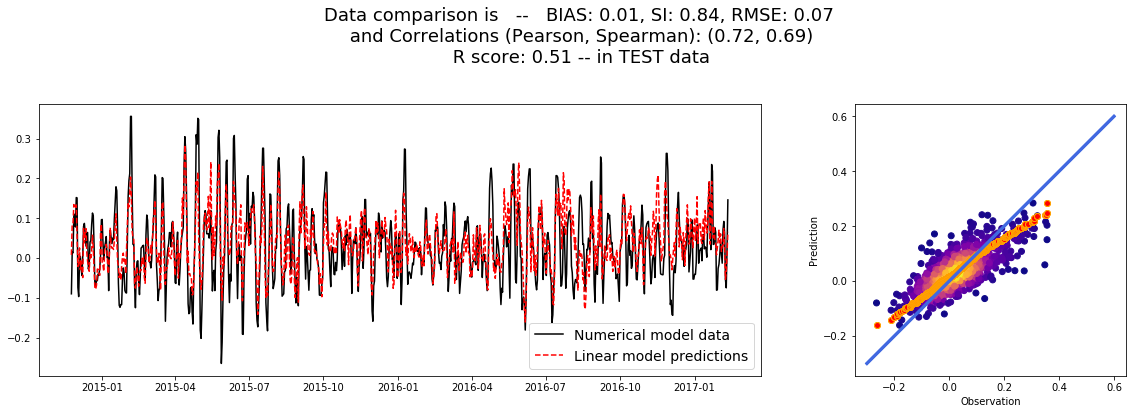

Data comparison is   --   BIAS: 0.01, SI: 0.84, RMSE: 0.07
 and Correlations (Pearson, Spearman): (0.72, 0.69)
 R score: 0.51 -- in TEST data


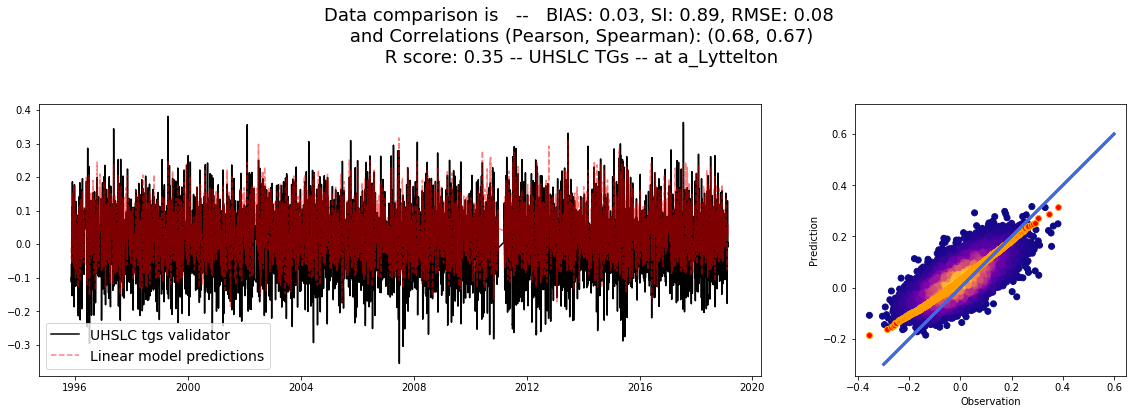


 139 PCs (0.95 expl. variance) will be used to train the model!! 



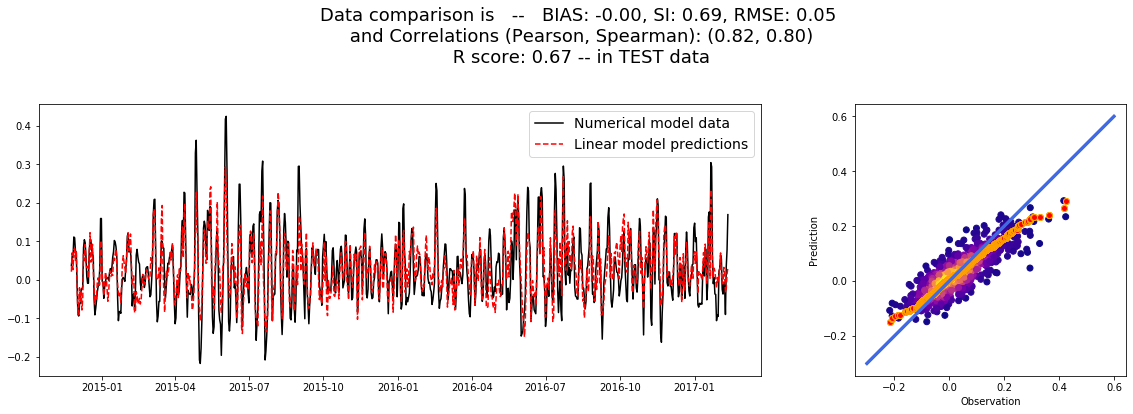

Data comparison is   --   BIAS: -0.00, SI: 0.69, RMSE: 0.05
 and Correlations (Pearson, Spearman): (0.82, 0.80)
 R score: 0.67 -- in TEST data


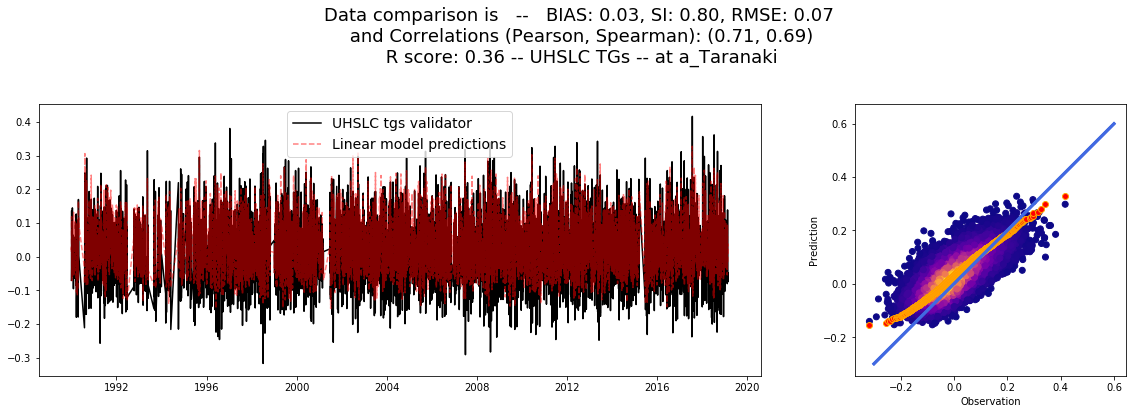


 139 PCs (0.95 expl. variance) will be used to train the model!! 



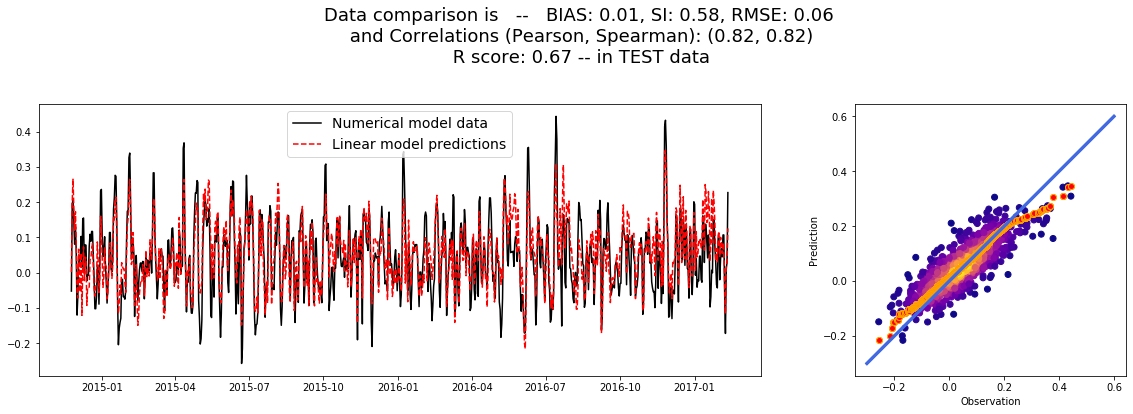

Data comparison is   --   BIAS: 0.01, SI: 0.58, RMSE: 0.06
 and Correlations (Pearson, Spearman): (0.82, 0.82)
 R score: 0.67 -- in TEST data


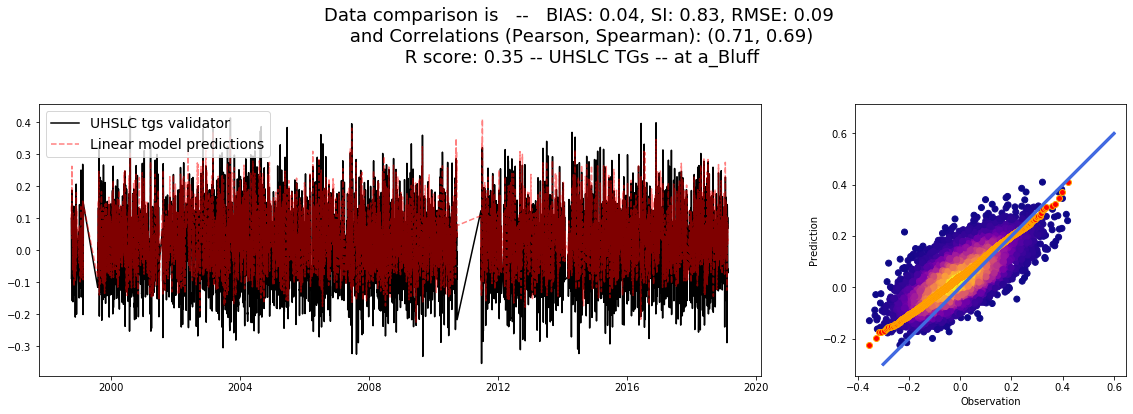


 139 PCs (0.95 expl. variance) will be used to train the model!! 



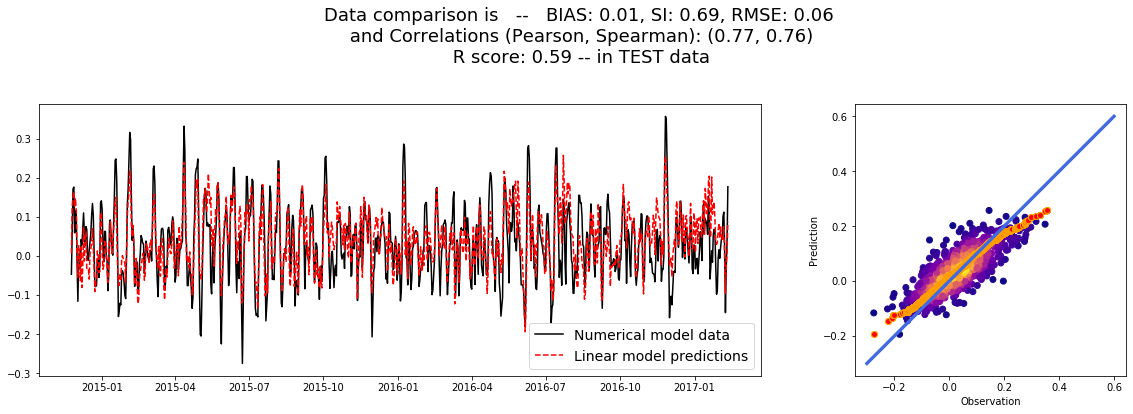

Data comparison is   --   BIAS: 0.01, SI: 0.69, RMSE: 0.06
 and Correlations (Pearson, Spearman): (0.77, 0.76)
 R score: 0.59 -- in TEST data


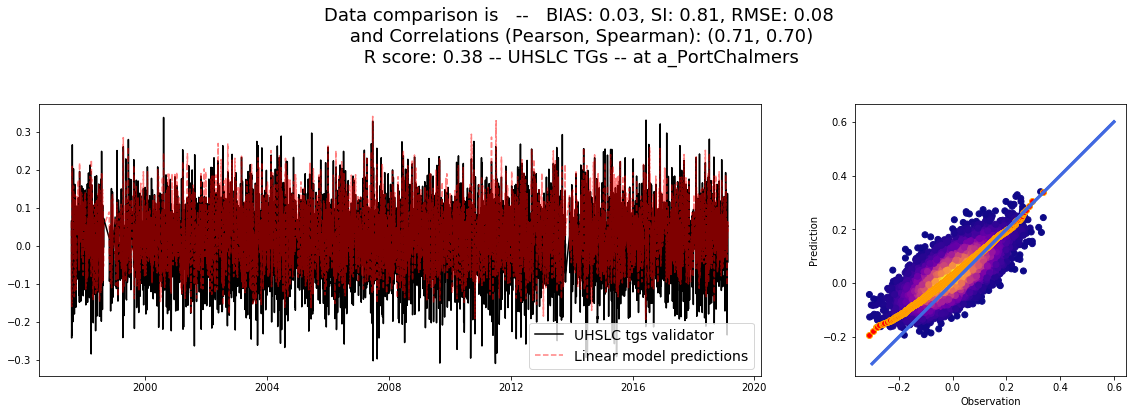


 139 PCs (0.95 expl. variance) will be used to train the model!! 



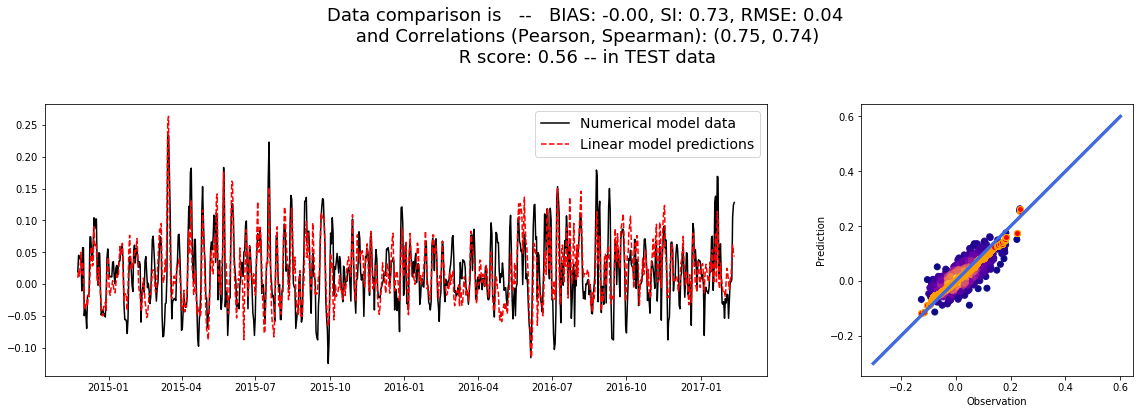

Data comparison is   --   BIAS: -0.00, SI: 0.73, RMSE: 0.04
 and Correlations (Pearson, Spearman): (0.75, 0.74)
 R score: 0.56 -- in TEST data


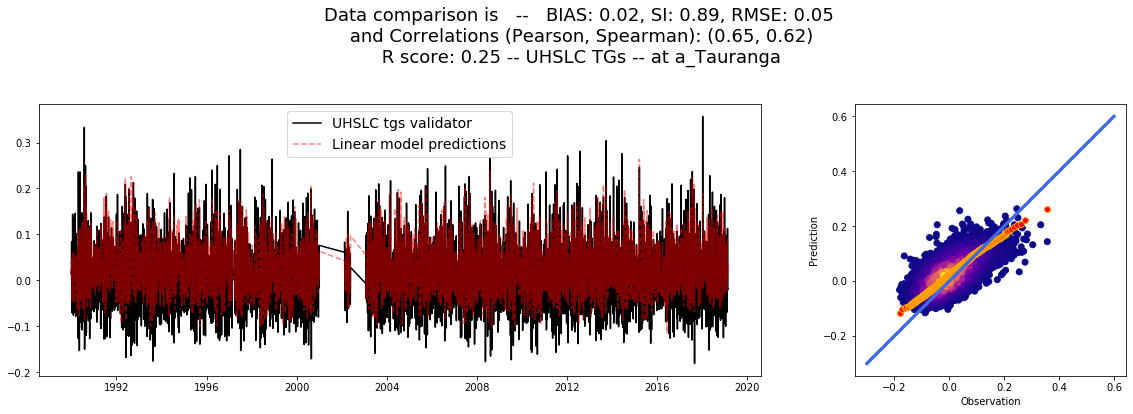


 139 PCs (0.95 expl. variance) will be used to train the model!! 



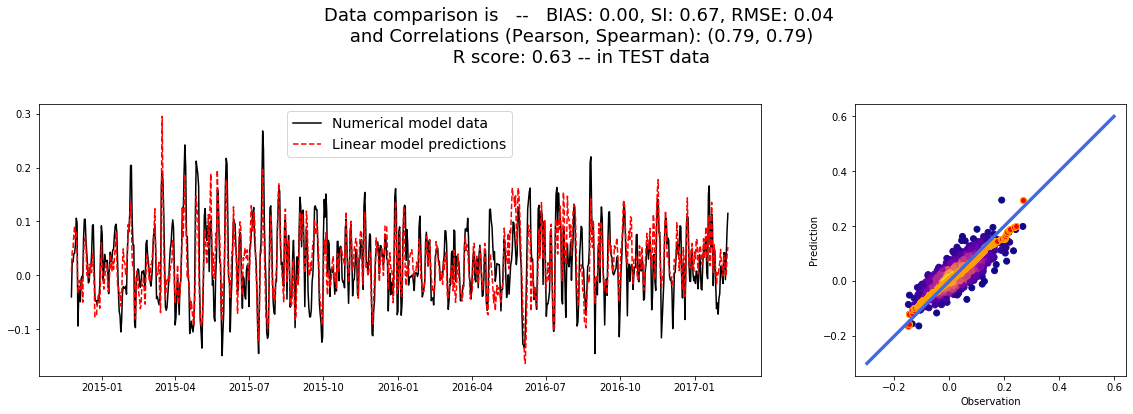

Data comparison is   --   BIAS: 0.00, SI: 0.67, RMSE: 0.04
 and Correlations (Pearson, Spearman): (0.79, 0.79)
 R score: 0.63 -- in TEST data


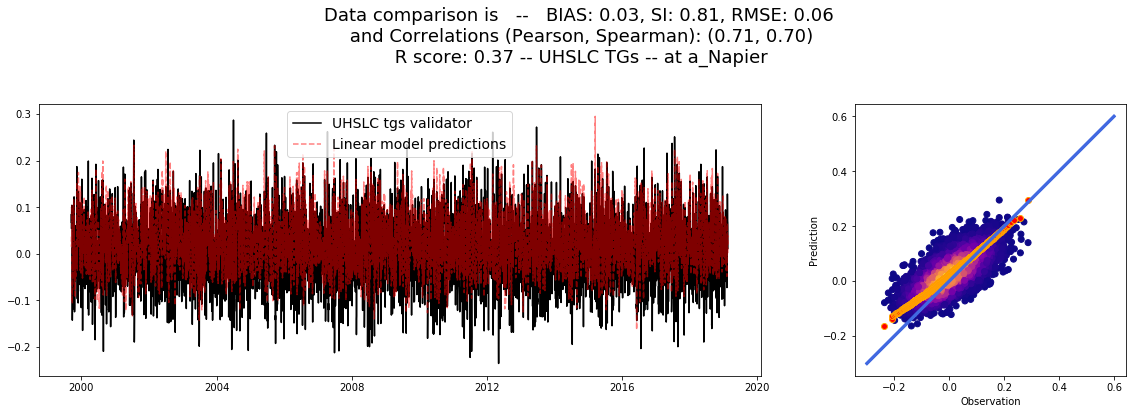


 139 PCs (0.95 expl. variance) will be used to train the model!! 



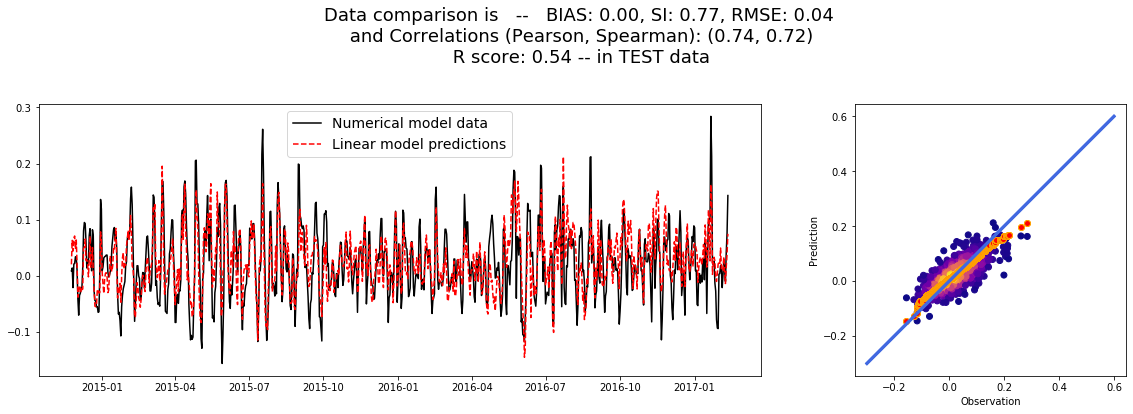

Data comparison is   --   BIAS: 0.00, SI: 0.77, RMSE: 0.04
 and Correlations (Pearson, Spearman): (0.74, 0.72)
 R score: 0.54 -- in TEST data


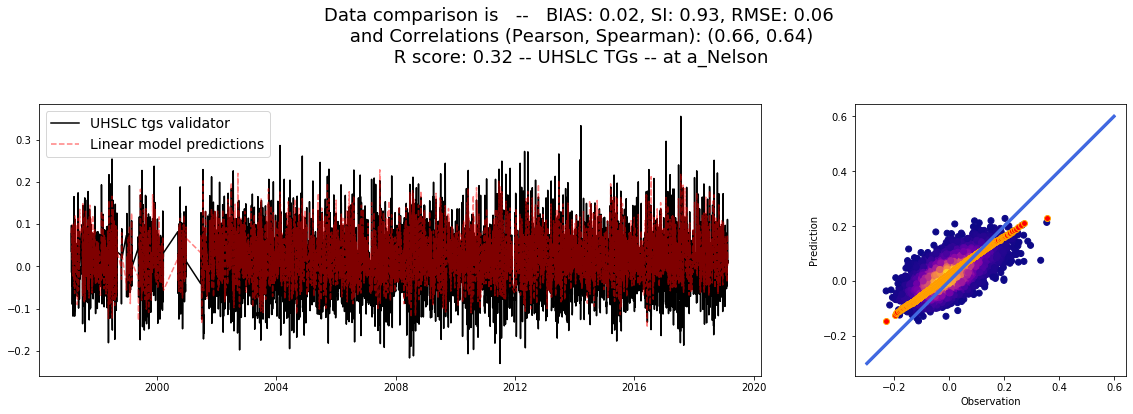

In [7]:
# validate model with tgs
stats = []
# select sites and append closest to UHSLC tgs
clos_to_uhslc = [689, 328, 393, 1327, 393, 480, 999, 116, 224, 1124, 949, 708]
for istat,stat in enumerate(clos_to_uhslc):
    ss_moana = load_cfsr_moana_uhslc.predictand.sel(site=stat)\
        .load().resample(time='1D').max()
    stats_stat = MultiLinear_Regression(
        pcs_cfsr, ss_moana, plot_results=True,
        validator=(
            True,load_cfsr_moana_uhslc.validator.isel(name=istat),'ss'
        )
    )
    stats.append(stats_stat)

### Linear regression - Ana's paper

In the following two cells, we do the regional-linear regression again, but this time we tarin the model with the tidal guages directly, just to see how our predictors are behaving when compared to results in previous works, as the one available at Rueda et al. 2018:

```{figure} ../media/images/anaetal.png
---
width: 700px
name: anaetal
---
Result from Rueda et al. and some more private tidal guages locations. Full paper available ([here](https://www.researchgate.net/publication/328587769_Marine_climate_variability_based_on_weather_patterns_for_a_complicated_island_setting_The_New_Zealand_case))
```


 loading and plotting the private tidal guages... 


 139 PCs (0.95 expl. variance) will be used to train the model!! 



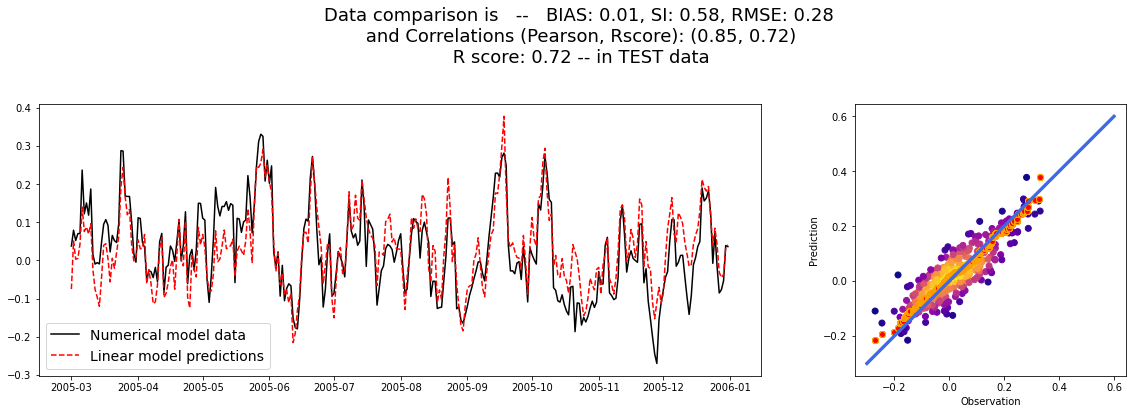

Data comparison is   --   BIAS: 0.01, SI: 0.58, RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.85, 0.72)
 R score: 0.72 -- in TEST data


In [13]:
# linear regression in kapiti island
ss_kapiti = load_private_tgs().sel(name='Kapiti_Is').resample(time='1D').max()
stats_stat = MultiLinear_Regression(
    pcs_cfsr, ss_kapiti, plot_results=True
)


 lets calculate the PCs... 


 adding the wind to the predictor... 


 winds predictor with shape: 
 (11354, 45, 51) 


 calculating PCs matrix with shape: 
 (11353, 4590) 


 plotting 1 components with 2 EOFs + PC... 


 being the EOFs the slp, the gradient, in steps t, t-1 



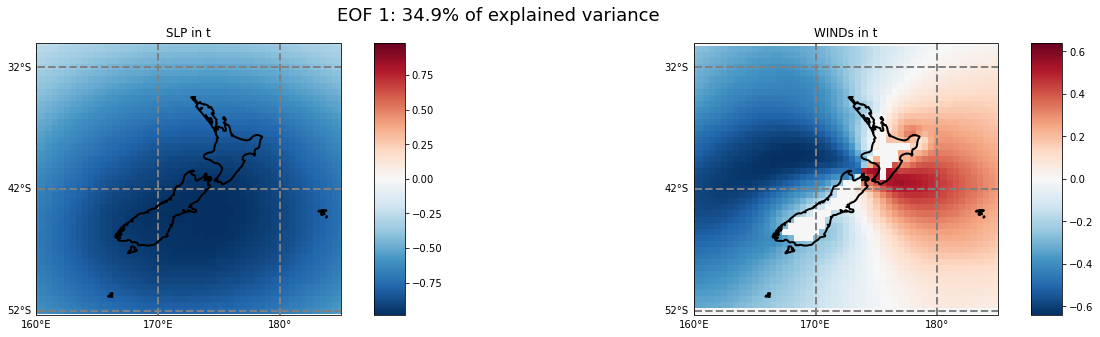

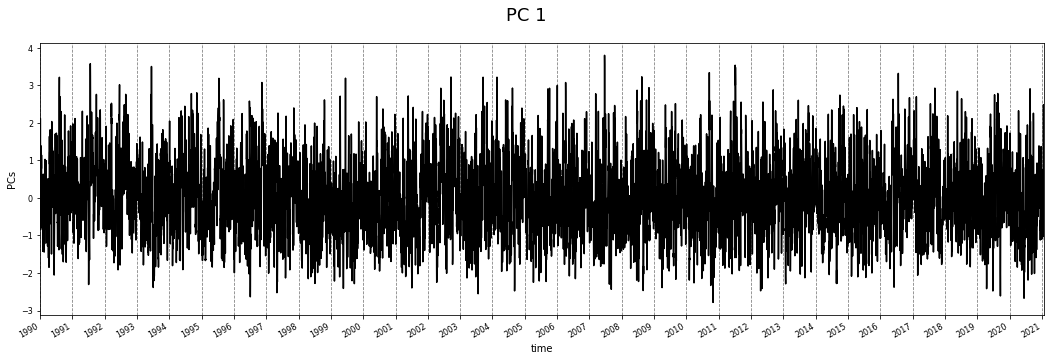


 12 PCs (0.95 expl. variance) will be used to train the model!! 



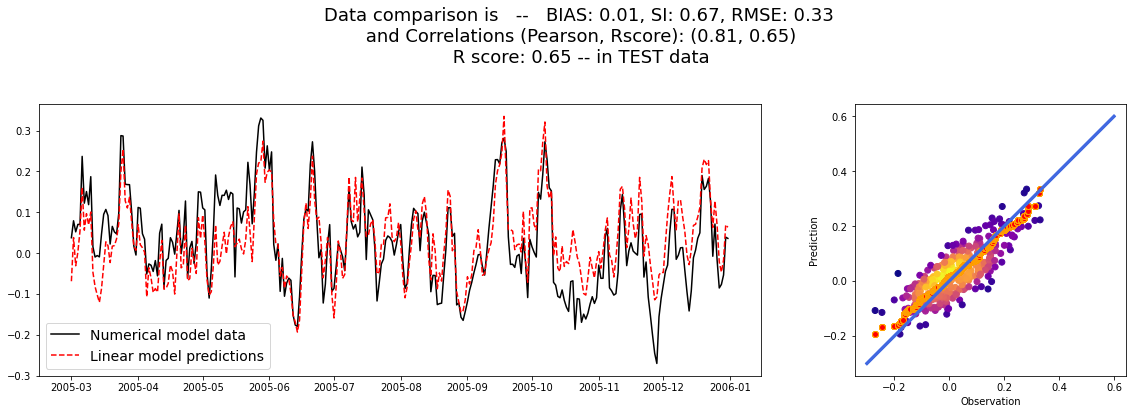

Data comparison is   --   BIAS: 0.01, SI: 0.67, RMSE: 0.33
 and Correlations (Pearson, Rscore): (0.81, 0.65)
 R score: 0.65 -- in TEST data


In [14]:
stats_stat = MultiLinear_Regression(
    PCA_DynamicPred(
        load_cfsr_moana_uhslc.predictor_slp,
        winds=(True,load_cfsr_moana_uhslc.predictor_wind),
        region=(True,default_region_reduced),
        pca_ttls=['SLP in t','WINDs in t'],
        pca_plot=(True,False,1)
    )[0], ss_kapiti, plot_results=True
)


 loading and plotting the private tidal guages... 


 139 PCs (0.95 expl. variance) will be used to train the model!! 



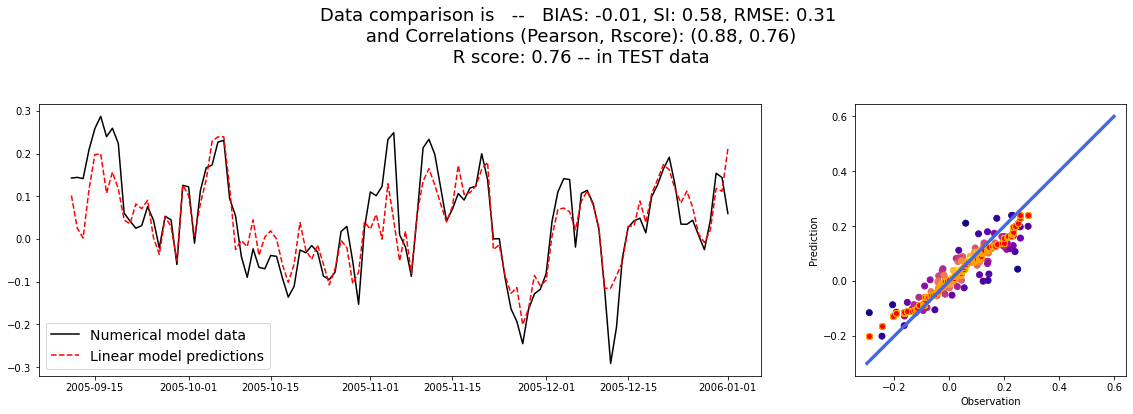

Data comparison is   --   BIAS: -0.01, SI: 0.58, RMSE: 0.31
 and Correlations (Pearson, Rscore): (0.88, 0.76)
 R score: 0.76 -- in TEST data


In [10]:
# linear regression in green island
ss_green = load_private_tgs().sel(name='Green_Is').resample(time='1D').max()
stats_stat = MultiLinear_Regression(
    pcs_cfsr, ss_green, plot_results=True
)

## Linear regression with local predictor

In the following cell, a multilinear regression is performed over all the domain of the Moana v2 hindcast nearshore, having the local pcs (slp + gradient) as the predictor. Moreover, we plot the obtained results, which are also saved in our `data/statistics` folder, with the name `stats_lm_local_daily.nc`. Notice that, with the regional predictor, which involves an area of 4 $\cdot$ 4 degrees, we are able to cover just a smaller area, but centered at the location of the virtual moana node.

```{note}
As it can be seen in the results plot, the different shores in New Zealand show very different results, as it could be seen with the regional predictor
```

In [10]:
run = False
if run:
    # perform the Multilinear-Regression (local)
    stats_local = []
    sites_local = np.arange(
        0,len(load_cfsr_moana_uhslc.predictand.site.values),10
    )
    for stat in progressbar.progressbar(sites_local):
        ss_moana = load_cfsr_moana_uhslc.predictand.sel(site=stat)\
            .load().resample(time='1D').max()
        stats_stat = MultiLinear_Regression(
            PCA_DynamicPred(
                load_cfsr_moana_uhslc.predictor_slp, 
                calculate_gradient=True, time_lapse=2,
                region=(True, (
                    ss_moana.lon.values[0]-2.1,
                    ss_moana.lon.values[0]+2.1,
                    ss_moana.lat.values[0]+2.1,
                    ss_moana.lat.values[0]-2.1
                )),
                pca_plot=False, verbose=False
            )[0],
            ss_moana, # tidal gauge (moana v2)
            verbose=False
        )
        stats_local.append(stats_stat)
    # save the statistics
    stats_local = xr.Dataset(
        data_vars={
            'bias':(('station'),np.array(stats_local)[:,0]),
            'si':(('station'),np.array(stats_local)[:,1]),
            'rmse':(('station'),np.array(stats_local)[:,2]),
            'pearson':(('station'),np.array(stats_local)[:,3]),
            'spearman':(('station'),np.array(stats_local)[:,4]),
            'rscore':(('station'),np.array(stats_local)[:,5]),
            'latitude':(('station'),
                load_cfsr_moana_uhslc.predictand.sel(site=sites_local).lat),
            'longitude':(('station'),
                load_cfsr_moana_uhslc.predictand.sel(site=sites_local).lon)
        },
        coords={
            'station': sites_local
        }
    )
    # local copy
    if False:
        stats_local.to_netcdf(
            data_path+'/statistics/models/stats_lm_local_daily.nc'
        )
else:
    stats_local = xr.open_dataset(
        data_path+'/statistics/models/stats_lm_local_daily.nc'
    )

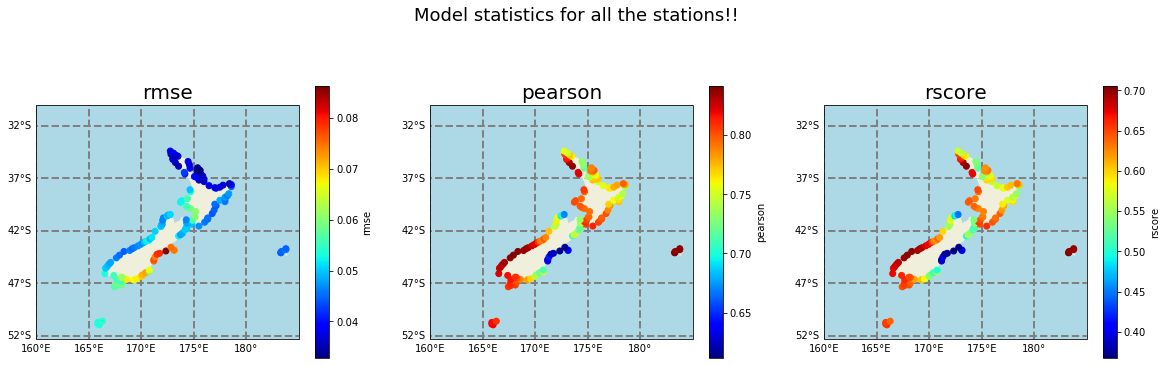

In [11]:
# plot results
if True:
    from sscode.plotting.validation import plot_stats
    plot_stats(stats_local,plot_stats=['rmse','pearson','rscore'])